In [48]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# from skforecast.ForecasterAutoreg import ForecasterAutoreg

os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [25]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/195733
Connected. Call `.close()` to terminate connection gracefully.


In [26]:
weather_fg = fs.get_feature_group(name="weather", version=3)
query = weather_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="weather",
                                             version=3,
                                             description="Read from Weather",
                                             query=query)

In [27]:
# set up dates
train_start = "1996-02-01 22:00:00"
train_end = "2020-02-01 22:00:00"
test_start = "2020-02-01 22:00:00"
test_end = "2024-01-03 08:00:00"

# create a train-test split dataset
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end
)

Finished: Reading data from Hopsworks, using ArrowFlight (5.94s) 


In [28]:
print(X_train.columns)
print(X_test.columns)
# print(y_train.info())
# print(y_test.info())
# X_train = X_train.reset_index()
# X_test = X_test.reset_index()
X_train = X_train.set_index("date_time")
X_test = X_test.set_index("date_time")
X_train = X_train.asfreq('h')
X_test = X_test.asfreq('h')
X_train = X_train.drop(columns=["id"])
X_test = X_test.drop(columns=["id"])
print(X_train.columns)
print(X_test.columns)

Index(['date_time', 'lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')
Index(['date_time', 'lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')
Index(['lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur'],
      dtype='object')
Index(['lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur'],
      dtype='object')


In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210384 entries, 1996-02-01 22:00:00+00:00 to 2020-02-01 21:00:00+00:00
Freq: H
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   lufttemperatur             210384 non-null  float64
 1   vindriktning               210384 non-null  float64
 2   vindhastighet              210384 non-null  float64
 3   relativ_luftfuktighet      210384 non-null  float64
 4   nederbrdsmngd              210384 non-null  float64
 5   sikt                       210384 non-null  float64
 6   byvind                     210384 non-null  float64
 7   max_av_medelvindhastighet  210384 non-null  float64
 8   daggpunktstemperatur       210384 non-null  float64
dtypes: float64(9)
memory usage: 16.1 MB


In [30]:
X_train.head()

,lufttemperatur,vindriktning,vindhastighet,relativ_luftfuktighet,nederbrdsmngd,sikt,byvind,max_av_medelvindhastighet,daggpunktstemperatur
date_time,,,,,,,,,
1996-02-01 22:00:00+00:00,-7.7,252.0,1.1,98.0,0.0,31066.052812,1.8,2.7,-8.0
1996-02-01 23:00:00+00:00,-6.7,261.0,1.4,96.0,0.0,31066.225879,2.4,2.1,-7.3
1996-02-02 00:00:00+00:00,-6.2,252.0,1.1,95.0,0.0,31066.398947,1.9,1.8,-6.9
1996-02-02 01:00:00+00:00,-5.6,312.0,1.2,93.0,0.0,31066.572015,2.1,1.5,-6.6
1996-02-02 02:00:00+00:00,-5.5,289.0,0.9,94.0,0.0,31066.745083,2.3,1.4,-6.4


In [31]:
#X_train['combine'] = list(X_train.values)
window_size = 12

# training_window = sliding_window_view(X_train.values, (window_size, 1))
# training_data = training_window[:-1]
# training_target = training_window[1:, :, -1]
# test_window = sliding_window_view(X_test.values, (window_size, 1))
# test_data = test_window[:-1]
# test_target = test_window[1:, :, -1]

# training_data = training_data.reshape((training_data.shape[0], -1))
# training_target = training_target.reshape((training_target.shape[0], -1))
# test_data = test_data.reshape((test_data.shape[0], -1))
# test_target = test_target.reshape((test_target.shape[0], -1))

scaler = StandardScaler()
scaler.fit(X_train.values)

training_data = scaler.transform(X_train.values[:-1])
training_target = scaler.transform(X_train.values[1:])
test_data = scaler.transform(X_test.values[:-1])
test_target = scaler.transform(X_test.values[1:])

training_data = training_data.reshape((training_data.shape[0], 1, -1))
training_target = training_target.reshape((training_target.shape[0], 1, -1))
test_data = test_data.reshape((test_data.shape[0], 1, -1))
test_target = test_target.reshape((test_target.shape[0], 1, -1))

In [32]:
print(training_data.shape)
print(training_data[1])

(210383, 1, 9)
[[-1.54069061  0.8016186  -0.75013589  0.90128809 -0.16295775  0.15751493
  -0.96010164 -0.93846892 -1.3689724 ]]


In [33]:
print(training_target.shape)
print(training_target[0])

(210383, 1, 9)
[[-1.54069061  0.8016186  -0.75013589  0.90128809 -0.16295775  0.15751493
  -0.96010164 -0.93846892 -1.3689724 ]]


In [34]:
#forecaster = ForecasterAutoreg(
#                 regressor = RandomForestRegressor(random_state=123),
#                 lags      = 6,
#             )

#reg = RandomForestRegressor(random_state=123)

#forecaster.fit(y=X_train['combine'])
#forecaster

#reg.fit(training_data, training_target)

In [35]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(training_data.shape[1], training_data.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(9))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                12000     
                                                                 
 dense_1 (Dense)             (None, 9)                 459       
                                                                 
Total params: 12459 (48.67 KB)
Trainable params: 12459 (48.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# fit network
history = model.fit(training_data, training_target, epochs=50, batch_size=72, validation_data=(test_data, test_target), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Epoch 1/50
2922/2922 - 7s - loss: 0.5922 - val_loss: 0.6096 - 7s/epoch - 3ms/step
Epoch 2/50
2922/2922 - 8s - loss: 0.5922 - val_loss: 0.6096 - 8s/epoch - 3ms/step
Epoch 3/50


KeyboardInterrupt: 

In [38]:
#predictions = forecaster.predict(steps=4, exog=X_test.drop(columns=["lufttemperatur"]))
predictions = model.predict(test_data)
y_true = scaler.inverse_transform(test_target.reshape(predictions.shape))
y_pred = scaler.inverse_transform(predictions)
error_mse = mean_squared_error(
                 y_true = y_true,
                 y_pred = y_pred
             )
print(f"[Total] Test error (MSE): {error_mse}")
error_mse = mean_squared_error(
                 y_true = y_true[:, 0],
                 y_pred = y_pred[:, 0]
             )
print(f"[Temp] Test error (MSE): {error_mse}")

print(predictions[:5])
print(test_target[:5])
# error_mse = 0
# y_true = X_test["lufttemperatur"]
# for i in range(len(y_true)-4):
#     for s in range(4):
#         error_mse += (y_true[i+s] - predictions[i][s])**2 / (len(y_true) * 4)


1074/1074 [==============================] - 2s 1ms/step
[Total] Test error (MSE): 16263035.011784129
[Temp] Test error (MSE): 8.989589544837662
[[-0.17616987  0.3266564   0.2991734   0.55306923 -0.16225252 -0.7532252
   0.30663562  0.26710162  0.01993123]
 [-0.18053861  0.38171777  0.30021164  0.61251795 -0.16192128 -0.565185
   0.28934523  0.2646958   0.03689869]
 [-0.15176907  0.41276076  0.37782523  0.46951538 -0.16098908  0.14369772
   0.38011184  0.33550256  0.01018001]
 [-0.18977974  0.43331563  0.40311095  0.58294886 -0.16134757 -0.37469146
   0.40852338  0.37589073  0.00665278]
 [-0.21773331  0.41277054  0.33865035  0.7112584  -0.1618753  -0.76154876
   0.3731092   0.31131706  0.02270553]]
[[[-0.07008514  0.44438369  0.73258256  0.60502517 -0.16295775
   -0.58310277  0.46068926  0.4525018   0.21734453]]

 [[-0.02339925  0.48102317  1.294993    0.36801483 -0.16295775
    0.6230084   0.63828812  0.64435983  0.19068374]]

 [[-0.0467422   0.54514225  1.09048011  0.54577259 -0.1629

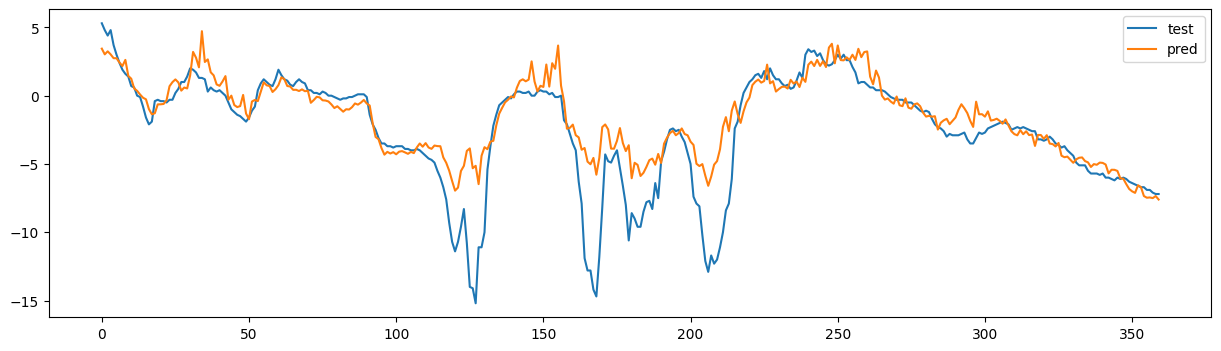

In [42]:
fig, ax = plt.subplots(figsize=(15, 4))
#training_target[:, 0].plot(ax=ax, label='train')
ax.plot(y_true[-24*15:, 0], label='test')
ax.plot(y_pred[-24*15:, 0], label='pred')
ax.legend();

In [73]:
runup = 12
duration = 48
data = test_data[1:runup+1].reshape((runup, -1))
while data.shape[0] < runup+duration:
    inp = data.reshape((data.shape[0], 1, -1))
    res = model.predict(inp, verbose=0)[-1:]
    data = np.concatenate((data, res), axis=0)
print("data shape", data.shape)

y_true = scaler.inverse_transform(test_target[:runup+duration].reshape(data.shape))
y_pred = scaler.inverse_transform(data)

error_mse = mean_squared_error(
                 y_true = y_true,
                 y_pred = y_pred
             )
print(f"[Total] Test error (MSE): {error_mse}")
error_mse = mean_squared_error(
                 y_true = y_true[:, 0],
                 y_pred = y_pred[:, 0]
             )
print(f"[Temp] Test error (MSE): {error_mse}")

data shape (60, 9)
[Total] Test error (MSE): 109430034.16234593
[Temp] Test error (MSE): 10.018692594604905


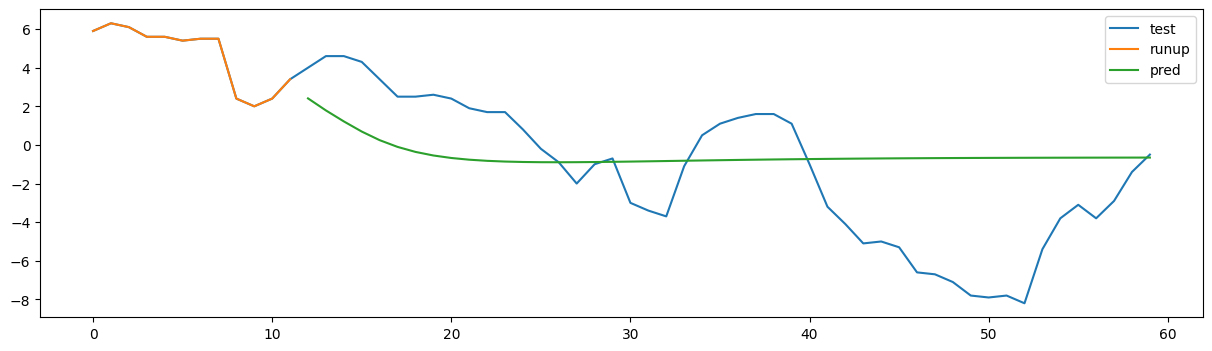

In [74]:
fig, ax = plt.subplots(figsize=(15, 4))
#training_target[:, 0].plot(ax=ax, label='train')
ax.plot(y_true[:, 0], label='test')
ax.plot(range(runup), y_pred[:runup, 0], label='runup')
ax.plot(range(runup, runup+duration), y_pred[runup:, 0], label='pred')
ax.legend();

In [ ]:
mr = project.get_model_registry()
model = reg

model_dir="temp_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/temp_model.pkl")
#fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(training_data[0])
output_schema = Schema(training_target[0])
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
temp_model = mr.python.create_model(
    name="temp_model", 
    metrics={"mse" : error_mse},
    model_schema=model_schema,
    description="Temperature Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
temp_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading model files (0 dirs, 0 files):  17%|█▋        | 1/6 [03:53<19:26, 233.30s/it]


KeyboardInterrupt: 